In [1]:
import os
import numpy as np
import pandas as pd
import cv2
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

In [2]:
# --- Load CSV ---
csv_path = "/scratch/pawsey1157/rtrivedi/dataset/Phenotypes/Images_GIDs_GRYLD.csv"
npy_dir = "/scratch/pawsey1157/rtrivedi/dataset/Phenotypes/stacked_npy/"
data_df = pd.read_csv(csv_path, header=None, names=['filename', 'GID', 'GRYLD'])

type((data_df.loc[1, 'GRYLD']))
#type(row['GRYLD'])

numpy.float64

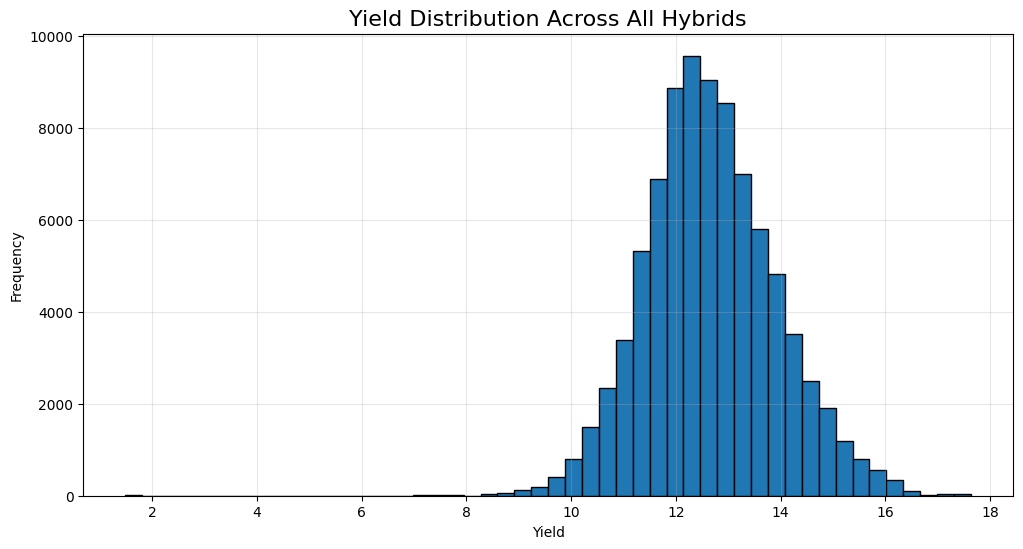

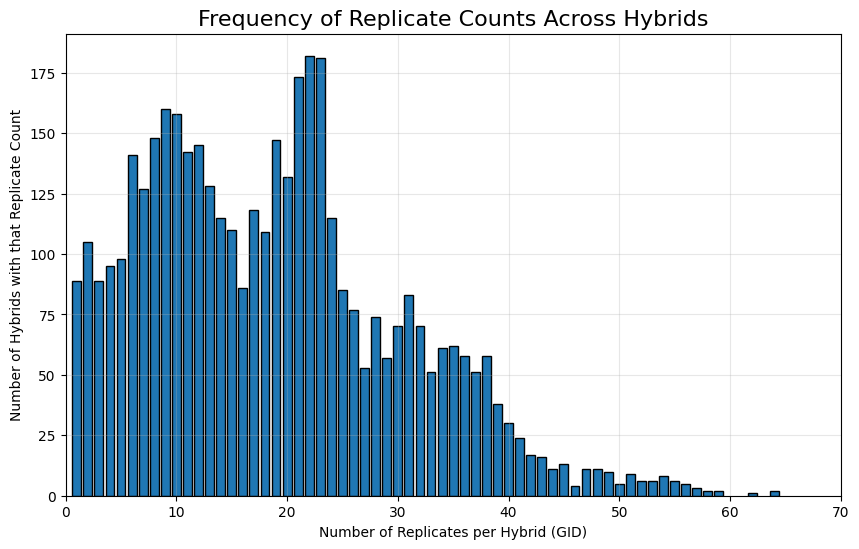

count
6     141
7     127
8     148
9     160
10    158
11    142
12    145
13    128
14    115
15    110
16     86
17    118
18    109
19    147
20    132
21    173
22    182
23    181
24    115
Name: count, dtype: int64


In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your data (adjust path if needed)
#Y = pd.read_csv("yield_data_reduced1.csv")  # columns: ['GID', 'yield']

# --- 1️⃣ Overall yield distribution ---
plt.figure(figsize=(12, 6))
plt.hist(data_df['GRYLD'], bins=50, edgecolor='black')
plt.title("Yield Distribution Across All Hybrids", fontsize=16)
plt.xlabel("Yield")
plt.ylabel("Frequency")
plt.grid(True, alpha=0.3)
plt.show()

# --- Count how many replicates per GID ---
rep_counts = data_df['GID'].value_counts()

# --- Count how many GIDs fall into each replicate count ---
rep_freq = rep_counts.value_counts().sort_index()

# --- Plot the frequency of replicate counts ---
plt.figure(figsize=(10, 6))
plt.bar(rep_freq.index, rep_freq.values, width=0.8, edgecolor='black')
plt.title("Frequency of Replicate Counts Across Hybrids", fontsize=16)
plt.xlabel("Number of Replicates per Hybrid (GID)")
plt.ylabel("Number of Hybrids with that Replicate Count")
plt.xlim([0, 70])
plt.grid(True, alpha=0.3)
plt.show()

print(rep_freq[5:24])

In [4]:
print(sum(rep_freq))

4245


In [3]:
# --- Load all .npy images into X, yield into Y ---
X = []
Y = []

In [4]:
for idx, row in data_df.iterrows():
    npy_path = os.path.join(npy_dir, str(row['filename']))
    if os.path.exists(npy_path):
        img = np.load(npy_path)  # Already resized (145, 61, 8)
        YLD = row['GRYLD']
        X.append(img)
        Y.append(YLD)
    else:
        print(f"Warning: {npy_path} not found, skipping.")

In [5]:
X = np.array(X)
Y = np.array(Y)

print("Loaded data shape:", X.shape)  # (samples, height, width, bands)
print("Yield shape:", Y.shape)


Loaded data shape: (85855, 145, 61, 8)
Yield shape: (85855,)


In [6]:
# --- Train-test split ---
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [ ]:
# --- Train-test split ---
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# --- Build CNN model ---
input_shape = X_train.shape[1:]  # (height, width, bands)

model = keras.Sequential([
    layers.Input(shape=input_shape),
    
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1)  # Single regression output for grain yield
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

model.summary()

# --- Train model ---
history = model.fit(X_train, Y_train, epochs=100, batch_size=16, validation_split=0.2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 145, 61, 32)       2336      
                                                                 
 max_pooling2d (MaxPooling2  (None, 72, 30, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 30, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 15, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 36, 15, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 18, 7, 128)        0

In [8]:
from tensorflow.keras.models import load_model
model = load_model("CNN.h5")

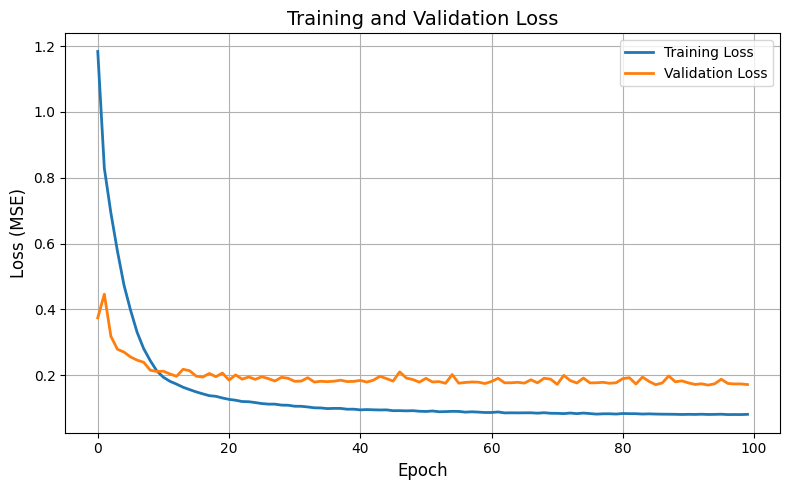

In [7]:
import matplotlib.pyplot as plt

# Assuming 'history' is the result from model.fit()
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.title('Training and Validation Loss', fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
import shap

# Sample a small number of background and test images
background = X_train
test_images = X_test

/software/projects/pawsey1157/rtrivedi/setonix/pythonEnvironments/tensorflowContainer_env/machinelearning/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
explainer = shap.GradientExplainer(model, background)
shap_values = explainer.shap_values(test_images)

print(np.array(shap_values).shape)  # (1, 10, height, width, bands)

Params set by AI: DeviceGroupedConvFwdMultipleABD_Xdl_CShuffle<256, 64, 128, 16, Default, 32, 32, 1, 2, 4, 4, 4, 1, 1, 1>
Params set by AI: DeviceGroupedConvFwdMultipleABD_Xdl_CShuffle<256, 128, 64, 16, OddC, 32, 32, 2, 1, 4, 4, 4, 1, 1, 1>
Params set by AI: DeviceGroupedConvFwdMultipleABD_Xdl_CShuffle<256, 64, 128, 16, OddC, 32, 32, 1, 2, 4, 4, 4, 1, 1, 1>
Params set by AI: DeviceGroupedConvFwdMultipleABD_Xdl_CShuffle<256, 64, 128, 16, Default, 32, 32, 1, 2, 4, 4, 4, 1, 1, 1>
Params set by AI: DeviceGroupedConvFwdMultipleABD_Xdl_CShuffle<256, 128, 64, 16, OddC, 32, 32, 2, 1, 4, 4, 4, 1, 1, 1>
Params set by AI: DeviceGroupedConvFwdMultipleABD_Xdl_CShuffle<256, 64, 128, 16, OddC, 32, 32, 1, 2, 4, 4, 4, 1, 1, 1>
(40, 145, 61, 8, 1)


In [13]:
from tqdm import tqdm

# --- Prepare background and test data ---
# Use a random subset of background samples to speed up computation
n_background = 100  # can adjust to 50–200 depending on memory
background = X_train[np.random.choice(X_train.shape[0], n_background, replace=False)]

# Use a subset of test images for SHAP if the full set is too large
n_test = 40  # adjust as needed
test_images = X_test[:n_test]

# --- Create SHAP DeepExplainer ---
explainer = shap.DeepExplainer(model, background)

# --- Compute SHAP values with progress bar ---
batch_size = 8  # tweak based on GPU memory
n_batches = int(np.ceil(len(test_images) / batch_size))
shap_values_list = []

print("🔍 Computing SHAP values for image-only CNN...")
for i in tqdm(range(n_batches), desc="SHAP batches", unit="batch"):
    batch = test_images[i * batch_size : (i + 1) * batch_size]
    shap_vals = explainer.shap_values(batch)
    shap_values_list.append(shap_vals)

# --- Concatenate results across batches ---
shap_values = [np.concatenate([b[i] for b in shap_values_list], axis=0)
               for i in range(len(shap_values_list[0]))]

print("✅ SHAP computation complete!")

/software/projects/pawsey1157/rtrivedi/setonix/pythonEnvironments/tensorflowContainer_env/machinelearning/lib/python3.10/site-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(


Params set by AI: DeviceGroupedConvFwdMultipleABD_Xdl_CShuffle<256, 64, 128, 16, Default, 32, 32, 1, 2, 4, 4, 4, 1, 1, 1>
Params set by AI: DeviceGroupedConvFwdMultipleABD_Xdl_CShuffle<256, 64, 128, 16, OddC, 32, 32, 1, 2, 4, 4, 4, 1, 1, 1>
Params set by AI: DeviceGroupedConvFwdMultipleABD_Xdl_CShuffle<256, 256, 128, 16, OddC, 32, 32, 4, 2, 4, 4, 4, 1, 1, 1>
🔍 Computing SHAP values for image-only CNN...


SHAP batches:   0%|                                                                            | 0/5 [00:00<?, ?batch/s]/usr/lib/python3.10/site-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


Params set by AI: DeviceGroupedConvFwdMultipleABD_Xdl_CShuffle<256, 64, 128, 16, OddC, 32, 32, 1, 2, 4, 4, 4, 1, 1, 1>
Params set by AI: DeviceGroupedConvFwdMultipleABD_Xdl_CShuffle<256, 64, 128, 16, OddC, 32, 32, 1, 2, 4, 4, 4, 1, 1, 1>
Params set by AI: DeviceGroupedConvFwdMultipleABD_Xdl_CShuffle<256, 64, 128, 16, OddC, 32, 32, 1, 2, 4, 4, 4, 1, 1, 1>


SHAP batches:  20%|█████████████▌                                                      | 1/5 [00:06<00:24,  6.06s/batch]

Params set by AI: DeviceGroupedConvFwdMultipleABD_Xdl_CShuffle<256, 128, 64, 16, Default, 32, 32, 2, 1, 4, 4, 4, 1, 1, 1>
Params set by AI: DeviceGroupedConvFwdMultipleABD_Xdl_CShuffle<256, 128, 64, 16, Default, 32, 32, 2, 1, 4, 4, 4, 1, 1, 1>
Params set by AI: DeviceGroupedConvFwdMultipleABD_Xdl_CShuffle<256, 128, 64, 16, Default, 32, 32, 2, 1, 4, 4, 4, 1, 1, 1>


SHAP batches: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.54s/batch]

✅ SHAP computation complete!


(145, 61, 8)
(145, 61)


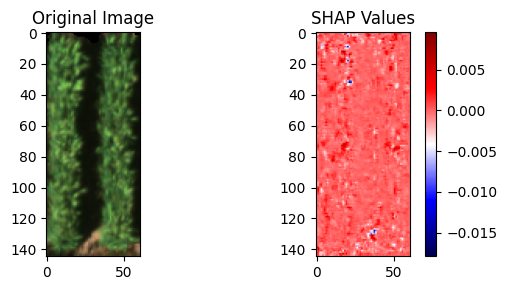

(145, 61, 8)
(145, 61)


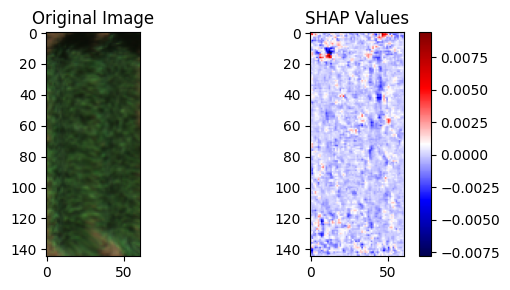

(145, 61, 8)
(145, 61)


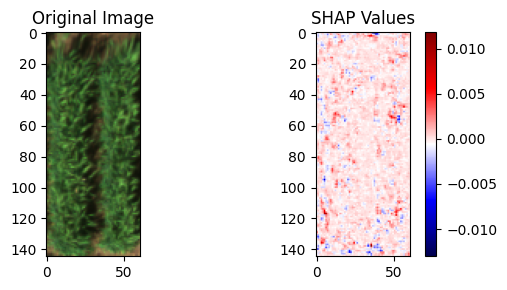

(145, 61, 8)
(145, 61)


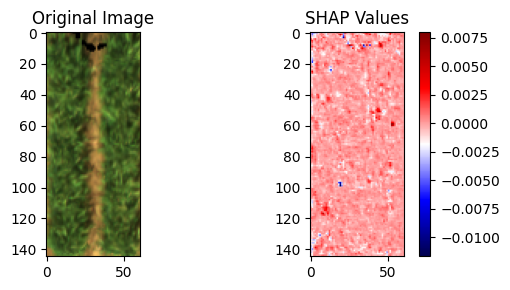

(145, 61, 8)
(145, 61)


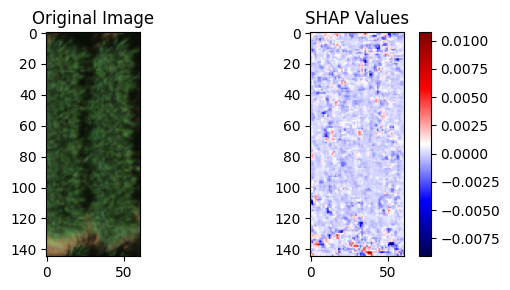

(145, 61, 8)
(145, 61)


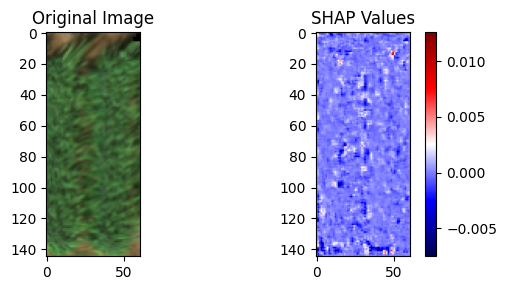

(145, 61, 8)
(145, 61)


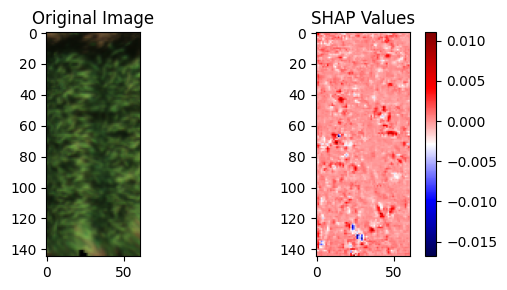

(145, 61, 8)
(145, 61)


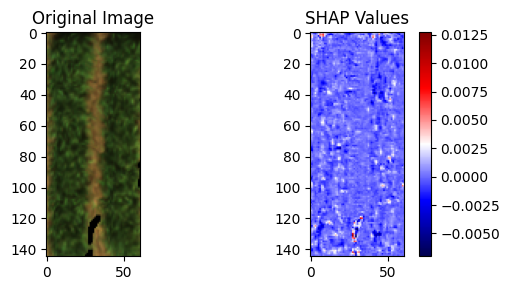

(145, 61, 8)
(145, 61)


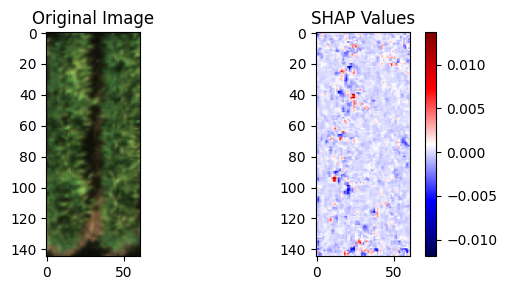

(145, 61, 8)
(145, 61)


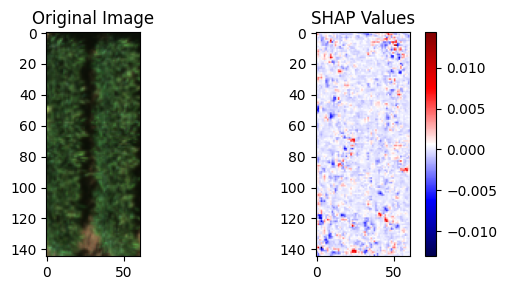

In [15]:
import matplotlib.pyplot as plt

for i in range(10):
    image = test_images[i, :, :, :3]
    shap_vals = shap_values[i][:, :, :, 0]
    print(shap_vals.shape)
    
    # Sum SHAP across channels for visualization (or pick one band)
#    shap_sum = shap_values[0][i,:,:,:]
#    print(shap_sum.shape)
    shap_band = shap_vals[:, :, 1] #last number depicts band
    print(shap_band.shape)
    
    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.imshow(image)  # normalize if needed
    plt.title("Original Image")
    
    plt.subplot(1, 2, 2)
    plt.imshow(shap_band, cmap='seismic')
    plt.title("SHAP Values")
    plt.colorbar()
    plt.tight_layout()
    plt.show()

In [9]:
# --- Evaluate ---
test_loss, test_mae = model.evaluate(X_test, Y_test)
print(f"Test MAE: {test_mae:.4f}")



537/537 [==============================] - 6s 10ms/step - loss: 0.1951 - mae: 0.3328
Test MAE: 0.3328


In [10]:
# --- Predict + check R² ---
Y_pred = model.predict(X_test).flatten()
r2 = r2_score(Y_test, Y_pred)
rmse = np.sqrt(mean_squared_error(Y_test, Y_pred))

print(f"R²: {r2:.3f}, RMSE: {rmse:.3f}")

537/537 [==============================] - 5s 10ms/step
R²: 0.637, RMSE: 0.442


In [10]:
model.save('CNN.h5')

/usr/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [16]:
print(f"Min: {image.min()}, Max: {image.max()}, Mean: {image.mean()}")


Min: 0.0, Max: 0.5399672985076904, Mean: 0.14588284492492676


Generating predictions...
Params set by AI: DeviceGroupedConvFwdMultipleABD_Xdl_CShuffle<256, 64, 128, 16, Default, 32, 32, 1, 2, 4, 4, 4, 1, 1, 1>
Params set by AI: DeviceGroupedConvFwdMultipleABD_Xdl_CShuffle<256, 128, 64, 16, OddC, 32, 32, 2, 1, 4, 4, 4, 1, 1, 1>
Params set by AI: DeviceGroupedConvFwdMultipleABD_Xdl_CShuffle<256, 128, 64, 16, Default, 32, 32, 2, 1, 4, 4, 4, 1, 1, 1>
2142/2147 [============================>.] - ETA: 0sParams set by AI: DeviceGroupedConvFwdMultipleABD_Xdl_CShuffle<256, 128, 64, 16, Default, 32, 32, 2, 1, 4, 4, 4, 1, 1, 1>
Params set by AI: DeviceGroupedConvFwdMultipleABD_Xdl_CShuffle<256, 128, 64, 16, Default, 32, 32, 2, 1, 4, 4, 4, 1, 1, 1>
Params set by AI: DeviceGroupedConvFwdMultipleABD_Xdl_CShuffle<256, 128, 64, 16, Default, 32, 32, 2, 1, 4, 4, 4, 1, 1, 1>
535/537 [============================>.] - ETA: 0sParams set by AI: DeviceGroupedConvFwdMultipleABD_Xdl_CShuffle<256, 128, 64, 16, Default, 32, 32, 2, 1, 4, 4, 4, 1, 1, 1>
Params set by AI: Dev

/tmp/ipykernel_1086200/896357509.py:61: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([train_errors, val_errors],


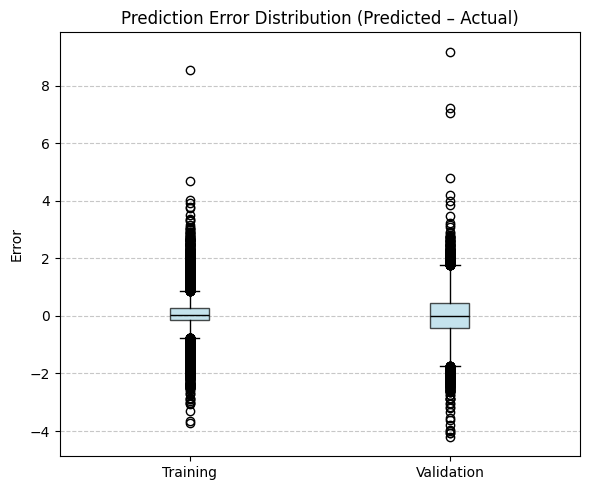

/tmp/ipykernel_1086200/896357509.py:83: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(residuals_by_bin,


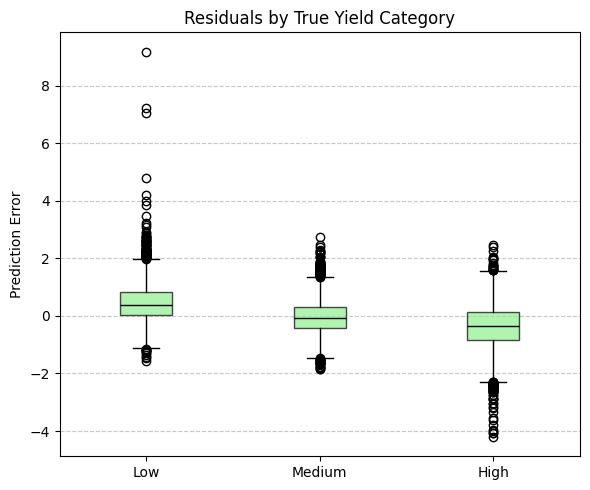

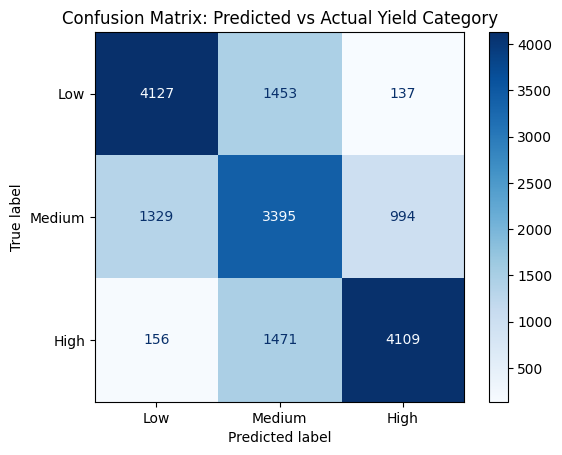

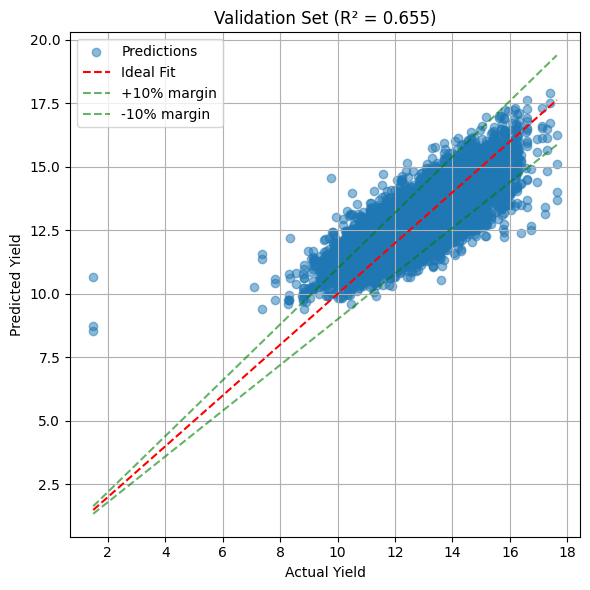

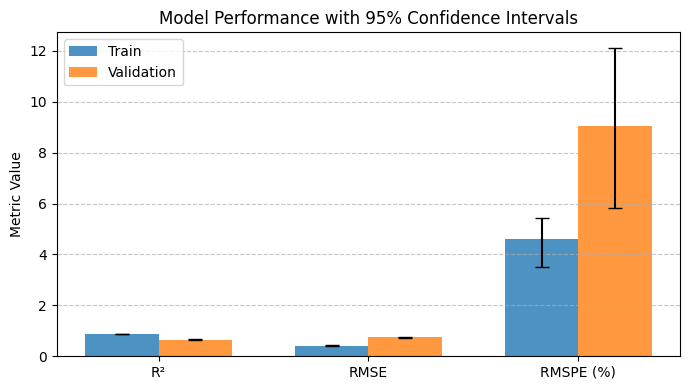

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, confusion_matrix, ConfusionMatrixDisplay

# --- 1. Metric functions ---
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def rmspe(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.sqrt(np.mean(((y_true[mask] - y_pred[mask]) / y_true[mask]) ** 2)) * 100

# --- 2. Bootstrapping confidence intervals ---
def bootstrap_ci(metric_func, y_true, y_pred, n_bootstrap=1000, ci=95):
    rng = np.random.default_rng(42)
    scores = []
    n = len(y_true)
    for _ in range(n_bootstrap):
        idx = rng.choice(np.arange(n), n, replace=True)
        scores.append(metric_func(y_true[idx], y_pred[idx]))
    lower = np.percentile(scores, (100 - ci) / 2)
    upper = np.percentile(scores, 100 - (100 - ci) / 2)
    return np.mean(scores), lower, upper

# --- 3. Generate predictions ---
print("Generating predictions...")
y_pred_train = model.predict(X_train).flatten()
y_pred_val = model.predict(X_test).flatten()

y_true_train = Y_train
y_true_val = Y_test

# --- 4. Compute metrics with bootstrap CIs for both sets ---
metrics_train = {
    'R²': bootstrap_ci(lambda yt, yp: r2_score(yt, yp), y_true_train, y_pred_train),
    'RMSE': bootstrap_ci(lambda yt, yp: rmse(yt, yp), y_true_train, y_pred_train),
    'RMSPE (%)': bootstrap_ci(lambda yt, yp: rmspe(yt, yp), y_true_train, y_pred_train),
}

metrics_val = {
    'R²': bootstrap_ci(lambda yt, yp: r2_score(yt, yp), y_true_val, y_pred_val),
    'RMSE': bootstrap_ci(lambda yt, yp: rmse(yt, yp), y_true_val, y_pred_val),
    'RMSPE (%)': bootstrap_ci(lambda yt, yp: rmspe(yt, yp), y_true_val, y_pred_val),
}

# --- 5. Print results ---
def print_metrics(label, metrics):
    print(f"\n{label} Metrics (with 95% CI):")
    for k, (mean, low, high) in metrics.items():
        print(f"  {k}: {mean:.4f}  (95% CI: {low:.4f} – {high:.4f})")

print_metrics("Training", metrics_train)
print_metrics("Validation", metrics_val)

# --- 6. Error distributions ---
train_errors = y_pred_train - y_true_train
val_errors = y_pred_val - y_true_val

plt.figure(figsize=(6, 5))
plt.boxplot([train_errors, val_errors],
            labels=["Training", "Validation"],
            patch_artist=True,
            medianprops=dict(color='black'),
            boxprops=dict(facecolor='lightblue', alpha=0.7))
plt.title("Prediction Error Distribution (Predicted – Actual)")
plt.ylabel("Error")
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# --- 7. Yield binning for residual analysis ---
percentiles = np.percentile(y_true_val, [33.3, 66.6])
bins = [y_true_val.min() - 1, percentiles[0], percentiles[1], y_true_val.max() + 1]
labels = ["Low", "Medium", "High"]

y_true_bins = np.digitize(y_true_val, bins) - 1
y_pred_bins = np.digitize(y_pred_val, bins) - 1

# --- 8. Boxplot of residuals by yield bin ---
residuals_by_bin = [val_errors[y_true_bins == i] for i in range(3)]
plt.figure(figsize=(6,5))
plt.boxplot(residuals_by_bin,
            labels=labels,
            patch_artist=True,
            medianprops=dict(color='black'),
            boxprops=dict(facecolor='lightgreen', alpha=0.7))
plt.title("Residuals by True Yield Category")
plt.ylabel("Prediction Error")
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# --- 9. Confusion matrix (predicted vs true yield bins) ---
cm = confusion_matrix(y_true_bins, y_pred_bins, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix: Predicted vs Actual Yield Category")
plt.show()

# --- 10. Predicted vs Actual scatter with ±10% band ---
def plot_pred_vs_actual_with_band(y_true, y_pred, title, band=0.1):
    plt.figure(figsize=(6,6))
    plt.scatter(y_true, y_pred, alpha=0.5, label="Predictions")
    min_val, max_val = np.min(y_true), np.max(y_true)
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label="Ideal Fit")

    # ±band lines (e.g., ±10%)
    plt.plot([min_val, max_val], [min_val*(1+band), max_val*(1+band)], 'g--', alpha=0.6, label=f"+{int(band*100)}% margin")
    plt.plot([min_val, max_val], [min_val*(1-band), max_val*(1-band)], 'g--', alpha=0.6, label=f"-{int(band*100)}% margin")

    plt.xlabel("Actual Yield")
    plt.ylabel("Predicted Yield")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_pred_vs_actual_with_band(
    y_true_val, y_pred_val,
    f"Validation Set (R² = {metrics_val['R²'][0]:.3f})"
)



# --- 11. Summary bar chart with CIs ---
labels_metrics = list(metrics_val.keys())
train_means = [metrics_train[m][0] for m in labels_metrics]
train_err_low = [metrics_train[m][0] - metrics_train[m][1] for m in labels_metrics]
train_err_high = [metrics_train[m][2] - metrics_train[m][0] for m in labels_metrics]
train_err = [train_err_high, train_err_low]

val_means = [metrics_val[m][0] for m in labels_metrics]
val_err_low = [metrics_val[m][0] - metrics_val[m][1] for m in labels_metrics]
val_err_high = [metrics_val[m][2] - metrics_val[m][0] for m in labels_metrics]
val_err = [val_err_high, val_err_low]

x = np.arange(len(labels_metrics))
width = 0.35

plt.figure(figsize=(7,4))
plt.bar(x - width/2, train_means, width, yerr=train_err, capsize=5, label="Train", alpha=0.8)
plt.bar(x + width/2, val_means, width, yerr=val_err, capsize=5, label="Validation", alpha=0.8)
plt.xticks(x, labels_metrics)
plt.ylabel("Metric Value")
plt.title("Model Performance with 95% Confidence Intervals")
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Yield Bin Summary (Validation Set):
Category   Range (t/ha)         Proportion (%) 
Low        0.49 – 12.10         33.3%
Medium     12.10 – 13.12         33.3%
High       13.12 – 18.63         33.4%


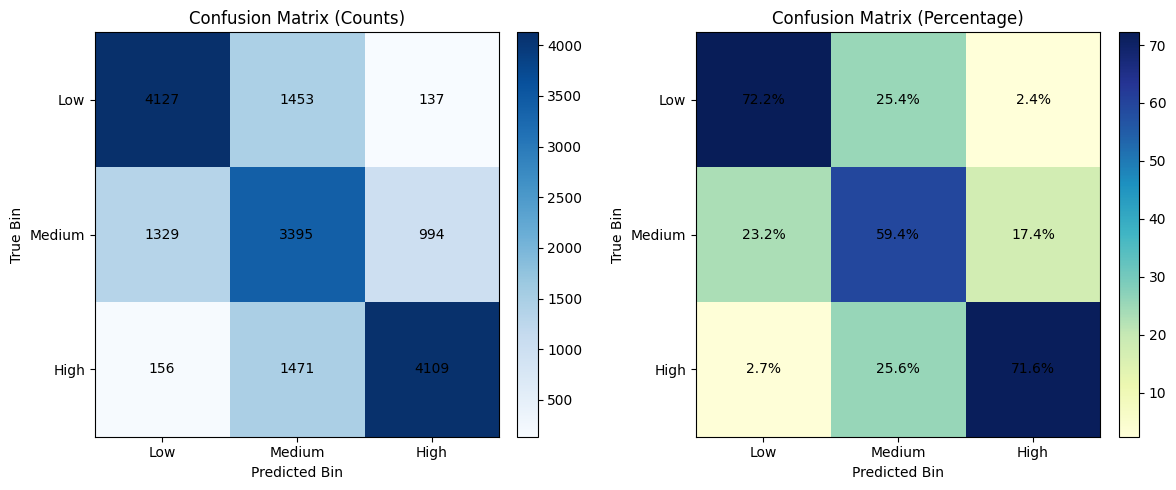


Normalized Confusion Matrix (%):
               Low       Medium      High   
Low              72.2       25.4        2.4
Medium           23.2       59.4       17.4
High              2.7       25.6       71.6


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# --- 1. Print bin range summary ---
bin_labels = ["Low", "Medium", "High"]

bin_ranges = [(bins[i], bins[i + 1]) for i in range(3)]
proportions = [np.sum(y_true_bins == i) / len(y_true_bins) * 100 for i in range(3)]

print("\nYield Bin Summary (Validation Set):")
print(f"{'Category':<10} {'Range (t/ha)':<20} {'Proportion (%)':<15}")
for lbl, (low, high), prop in zip(bin_labels, bin_ranges, proportions):
    print(f"{lbl:<10} {low:.2f} – {high:.2f} {prop:>12.1f}%")

# --- 2. Compute confusion matrices ---
cm = confusion_matrix(y_true_bins, y_pred_bins, labels=[0, 1, 2])
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True) * 100  # Normalize row-wise

# --- 3. Plot confusion matrices (counts and % side by side) ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Absolute counts
im1 = axes[0].imshow(cm, cmap='Blues')
axes[0].set_title("Confusion Matrix (Counts)")
axes[0].set_xlabel("Predicted Bin")
axes[0].set_ylabel("True Bin")
axes[0].set_xticks(np.arange(len(bin_labels)))
axes[0].set_yticks(np.arange(len(bin_labels)))
axes[0].set_xticklabels(bin_labels)
axes[0].set_yticklabels(bin_labels)

# Annotate
for i in range(len(bin_labels)):
    for j in range(len(bin_labels)):
        axes[0].text(j, i, cm[i, j], ha="center", va="center", color="black")

plt.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)

# Normalized (%)
im2 = axes[1].imshow(cm_norm, cmap='YlGnBu')
axes[1].set_title("Confusion Matrix (Percentage)")
axes[1].set_xlabel("Predicted Bin")
axes[1].set_ylabel("True Bin")
axes[1].set_xticks(np.arange(len(bin_labels)))
axes[1].set_yticks(np.arange(len(bin_labels)))
axes[1].set_xticklabels(bin_labels)
axes[1].set_yticklabels(bin_labels)

# Annotate with percentage values
for i in range(len(bin_labels)):
    for j in range(len(bin_labels)):
        axes[1].text(j, i, f"{cm_norm[i, j]:.1f}%", ha="center", va="center", color="black")

plt.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

# --- 4. Optional: Print numeric confusion matrix (percentages) ---
print("\nNormalized Confusion Matrix (%):")
print(" " * 12 + " ".join(f"{lbl:^10}" for lbl in bin_labels))
for i, lbl in enumerate(bin_labels):
    row = " ".join(f"{cm_norm[i, j]:10.1f}" for j in range(len(bin_labels)))
    print(f"{lbl:<10} {row}")

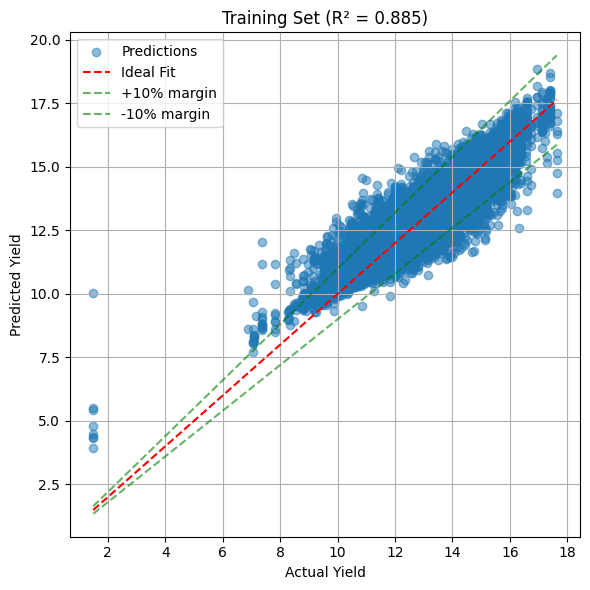

In [11]:
# --- 10. Predicted vs Actual scatter with ±10% band ---
def plot_pred_vs_actual_with_band(y_true, y_pred, title, band=0.1):
    plt.figure(figsize=(6,6))
    plt.scatter(y_true, y_pred, alpha=0.5, label="Predictions")
    min_val, max_val = np.min(y_true), np.max(y_true)
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label="Ideal Fit")

    # ±band lines (e.g., ±10%)
    plt.plot([min_val, max_val], [min_val*(1+band), max_val*(1+band)], 'g--', alpha=0.6, label=f"+{int(band*100)}% margin")
    plt.plot([min_val, max_val], [min_val*(1-band), max_val*(1-band)], 'g--', alpha=0.6, label=f"-{int(band*100)}% margin")

    plt.xlabel("Actual Yield")
    plt.ylabel("Predicted Yield")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_pred_vs_actual_with_band(
    y_true_train, y_pred_train,
    f"Training Set (R² = {metrics_train['R²'][0]:.3f})"
)

In [27]:
import numpy as np

# --- Get predictions ---
#y_pred = model.predict(X_test).flatten()

# --- Compute absolute errors ---
errors = np.abs(y_true_val - y_pred_val)

# --- Sort by error ---
sorted_idx = np.argsort(errors)
best_idx = sorted_idx[:5]   # 5 best predictions
worst_idx = sorted_idx[-5:] # 5 worst predictions

print("Best indices:", best_idx)
print("Worst indices:", worst_idx)

Best indices: [ 1324 13680  5179 12130  9365]
Worst indices: [ 9670  1999 15838  7191  9681]


In [31]:
print(errors)


[0.96686254 1.24434073 0.64913339 ... 1.45574518 1.37969383 0.42937107]


In [33]:
import shap
import tensorflow as tf

# --- Background sample ---
background = X_train[np.random.choice(X_train.shape[0], 20, replace=False)]

# --- Create SHAP explainer ---
explainer = shap.GradientExplainer(model, background)

# --- Select samples from the same validation arrays ---
selected_idx = np.concatenate([best_idx, worst_idx])

X_selected = X_test[selected_idx]
y_true_selected = y_true_val[selected_idx]
y_pred_selected = y_pred_val[selected_idx]

In [34]:
# --- Compute SHAP values ---
shap_values = explainer.shap_values(X_selected)
shap_vals = shap_values[0] if isinstance(shap_values, list) else shap_values
shap_sum = np.sum(np.abs(shap_vals), axis=-1)  # (n_samples, H, W)

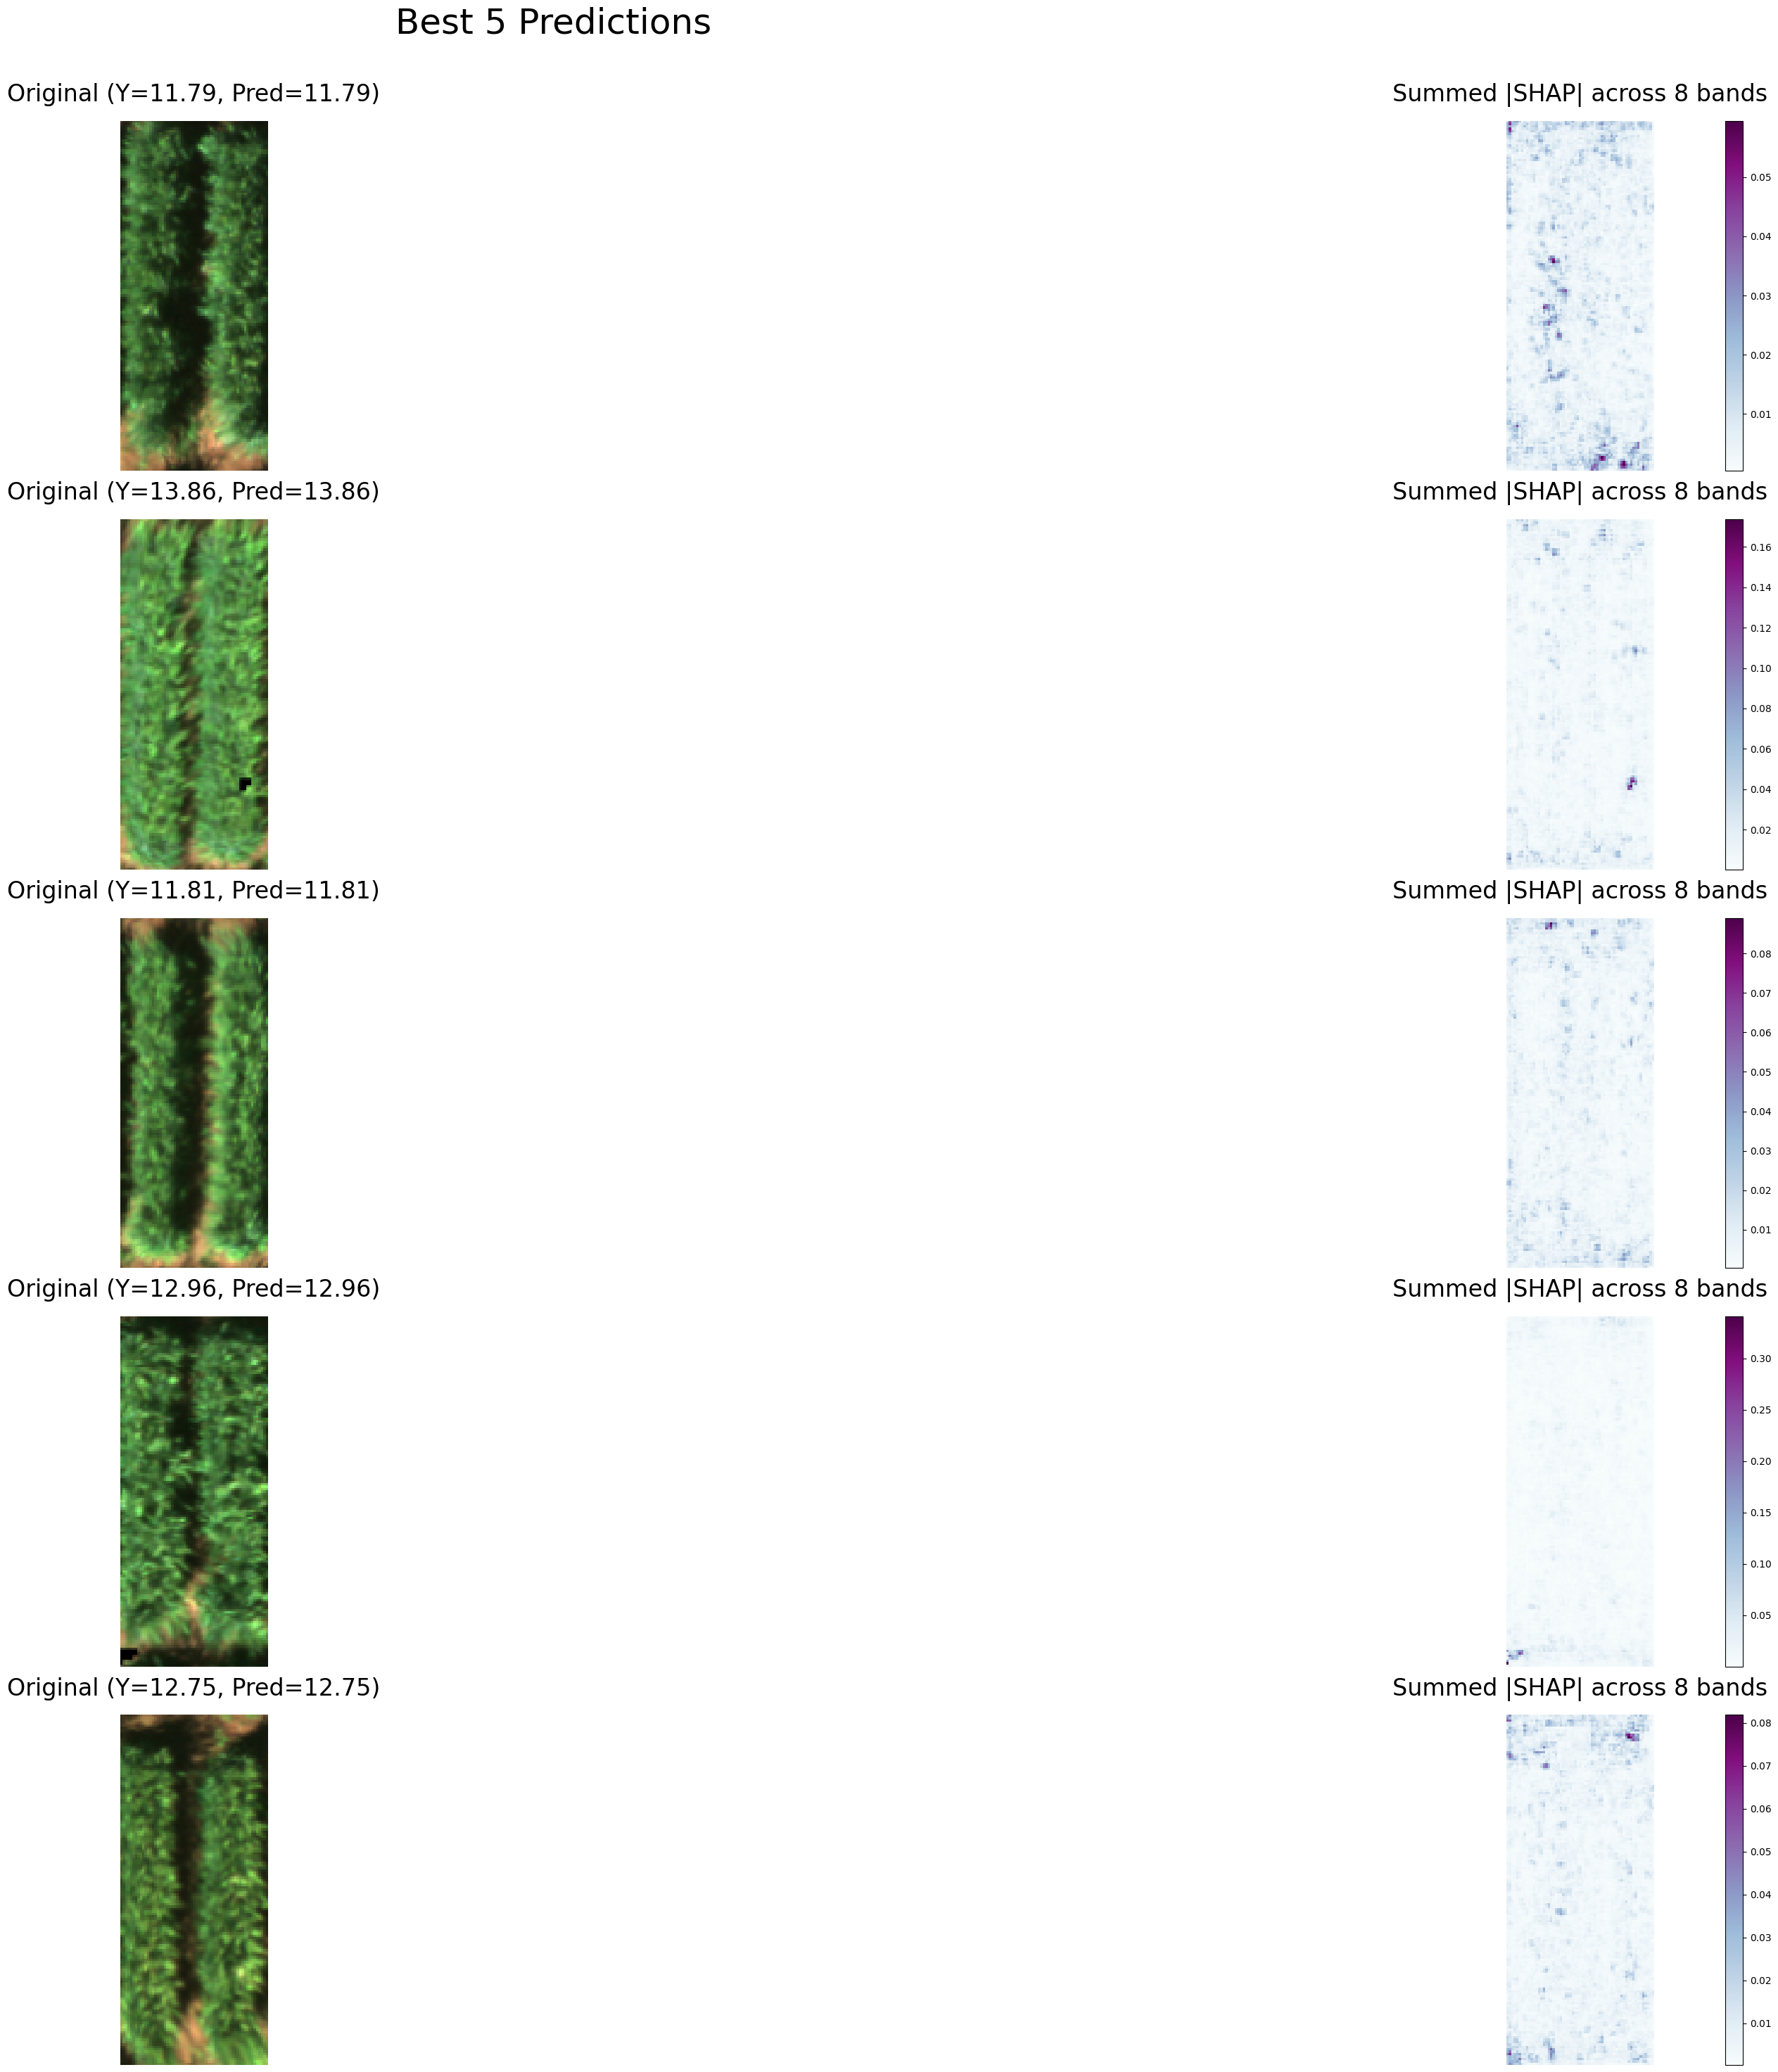

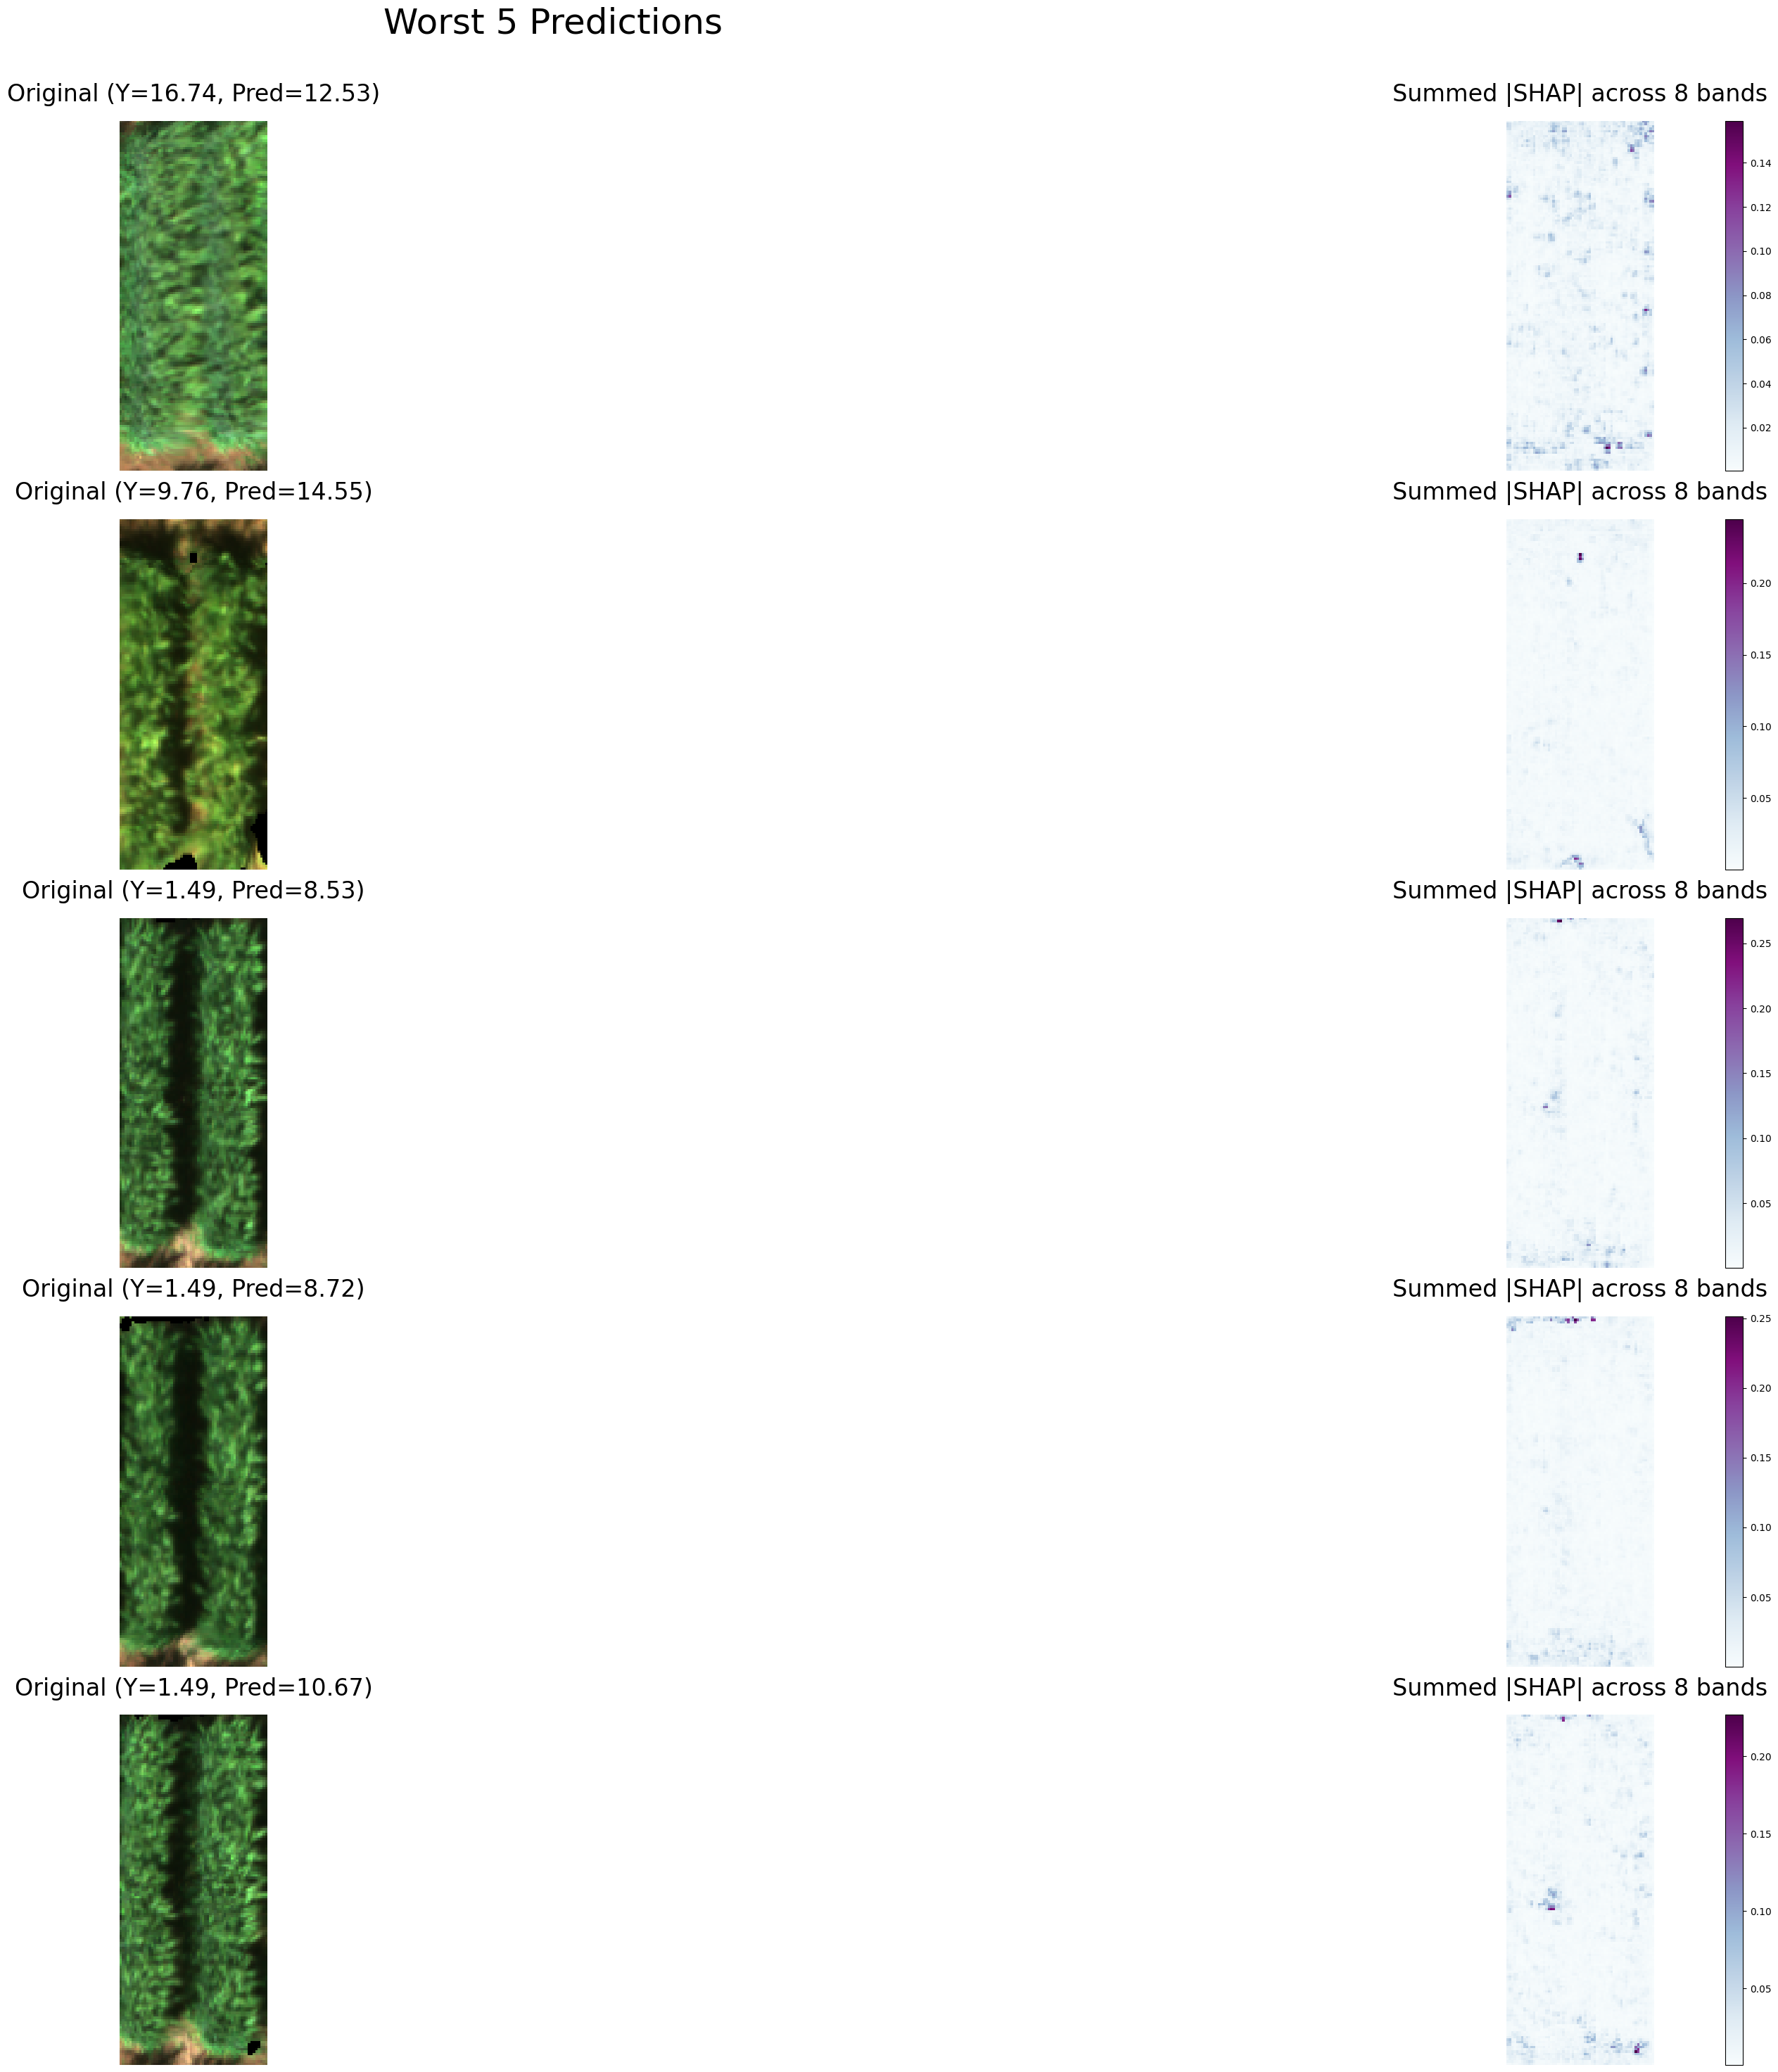

In [45]:
import matplotlib.pyplot as plt

def plot_shap_images(X, shap_sum, y_true, y_pred, indices, title):
    # Make figure 3× larger (was 12x10 → now 36x30)
    plt.figure(figsize=(36, 30))
    
    for i, idx in enumerate(indices):
        img = X[idx, :, :, :3]  # use first 3 bands as RGB proxy
        shap_img = shap_sum[idx]

        # --- Original Image ---
        plt.subplot(5, 2, 2*i + 1)
        plt.imshow(img / np.max(img))  # normalize for display
        plt.title(f"Original (Y={y_true[idx]:.2f}, Pred={y_pred[idx]:.2f})",
                  fontsize=24, pad=20)
        plt.axis("off")

        # --- SHAP Heatmap ---
        plt.subplot(5, 2, 2*i + 2)
        im = plt.imshow(np.sum(np.abs(shap_img), axis=-1), cmap='BuPu')
        plt.title("Summed |SHAP| across 8 bands", fontsize=24, pad=20)
        plt.colorbar(im, fraction=0.046, pad=0.04)
        plt.axis("off")

    plt.suptitle(title, fontsize=36, y=0.98)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

# --- Plot best and worst ---
plot_shap_images(X_selected, shap_sum, y_true_selected, y_pred_selected, range(0, 5), "Best 5 Predictions")
plot_shap_images(X_selected, shap_sum, y_true_selected, y_pred_selected, range(5, 10), "Worst 5 Predictions")




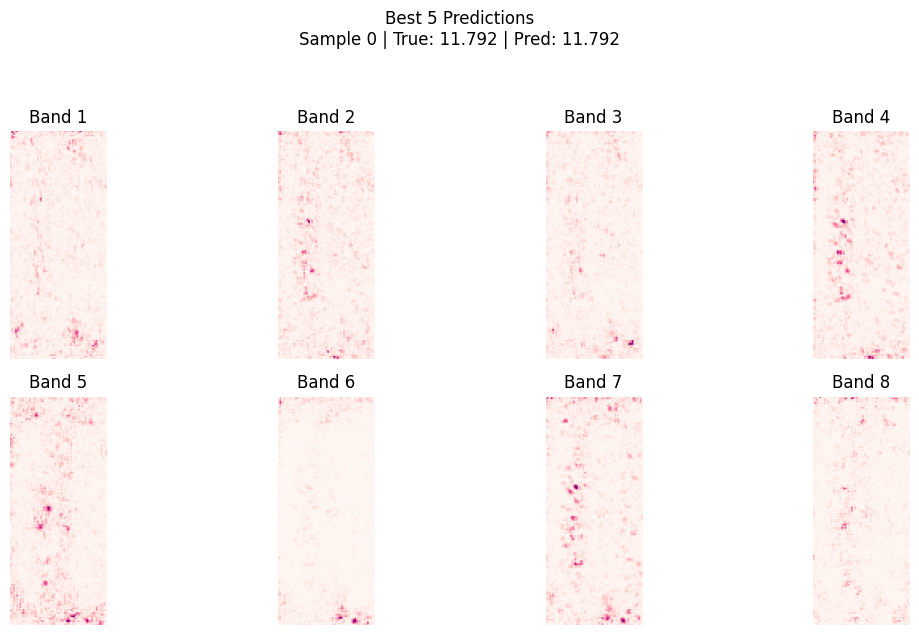

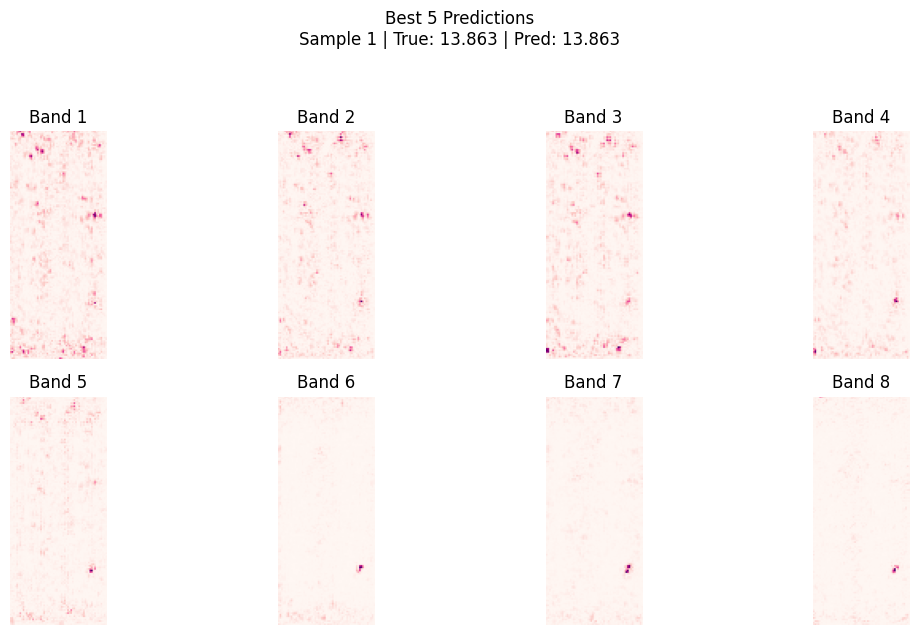

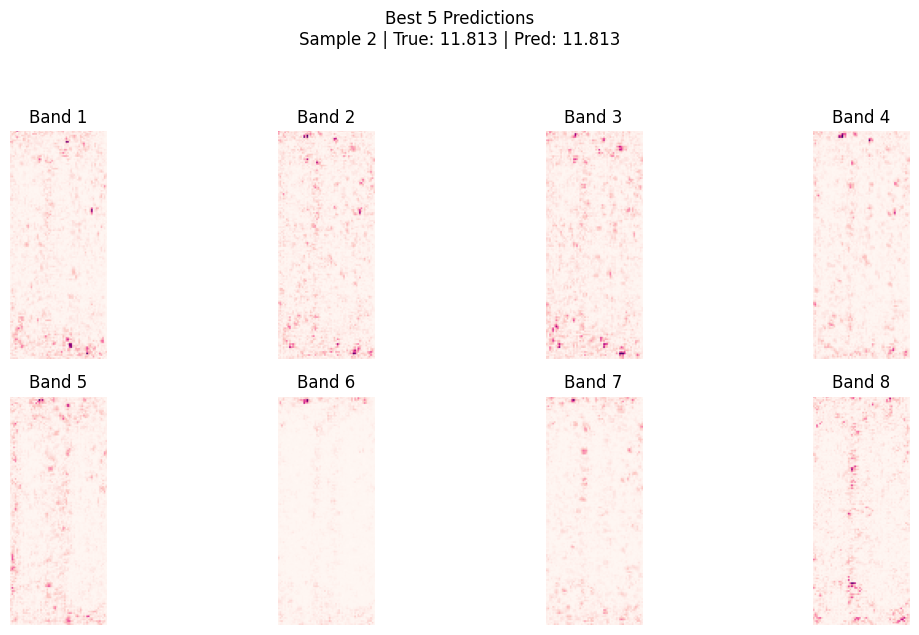

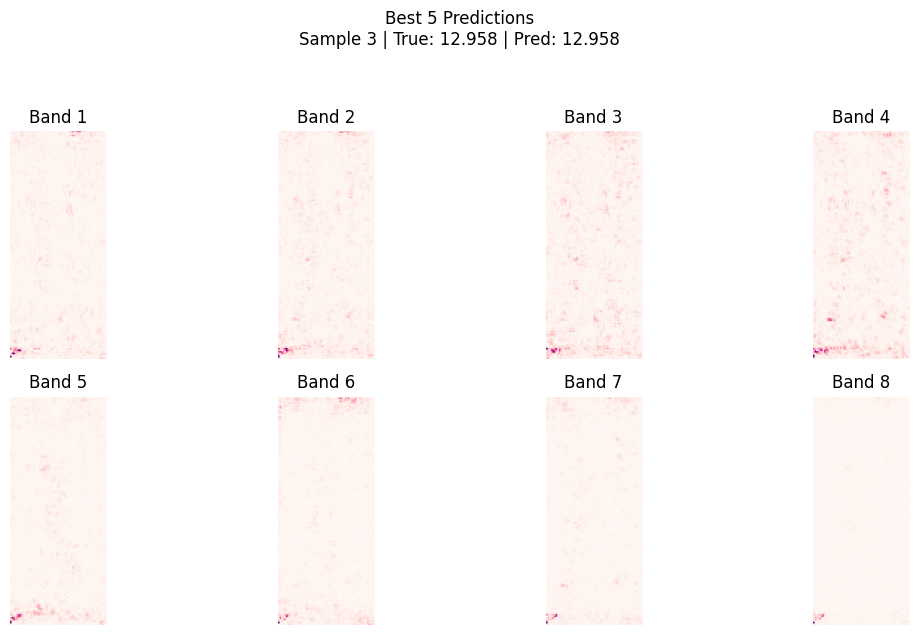

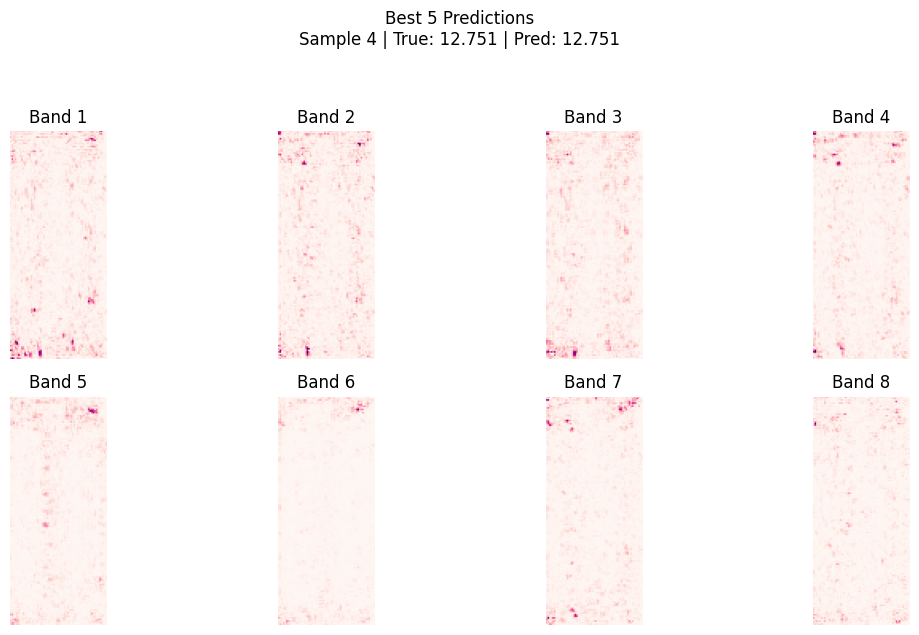

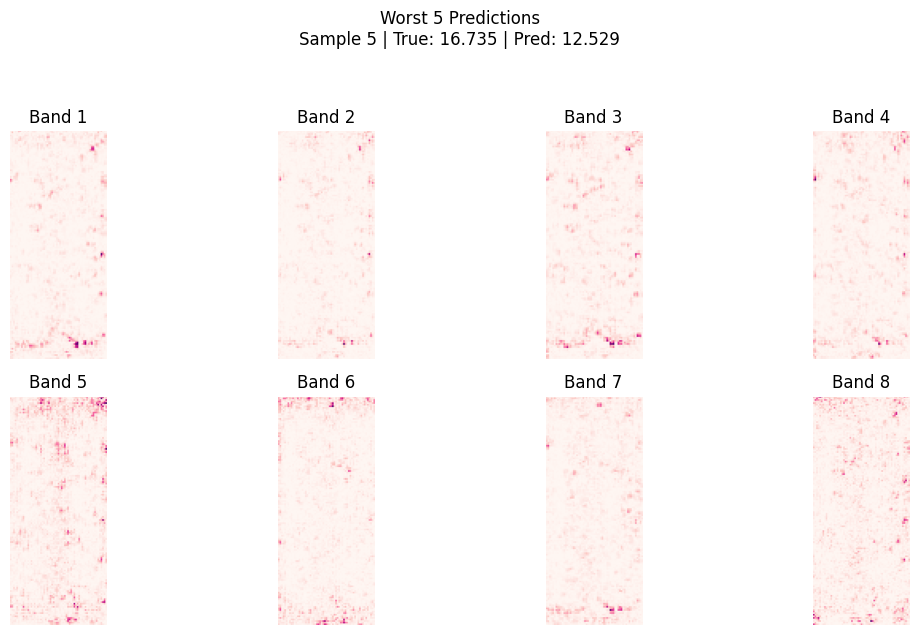

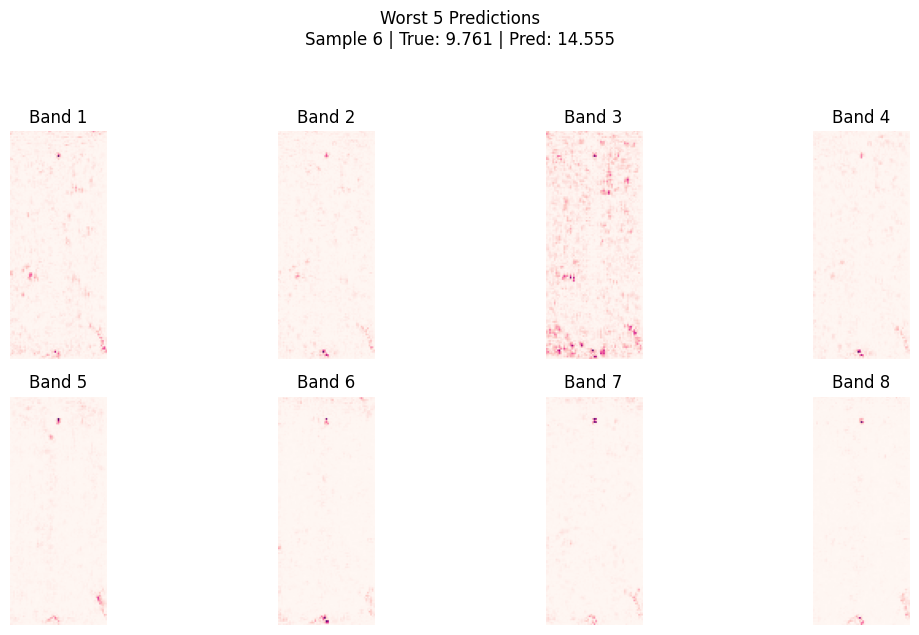

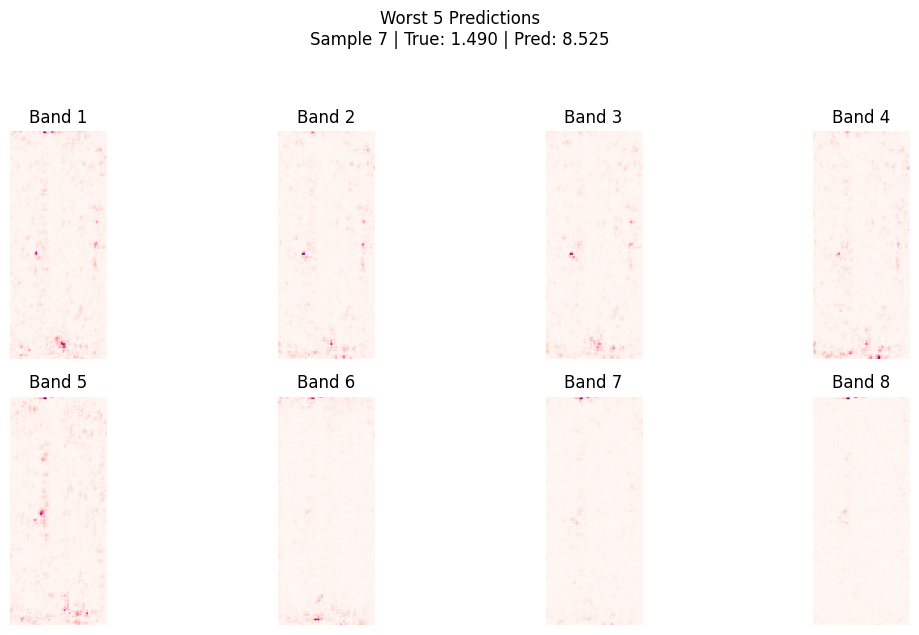

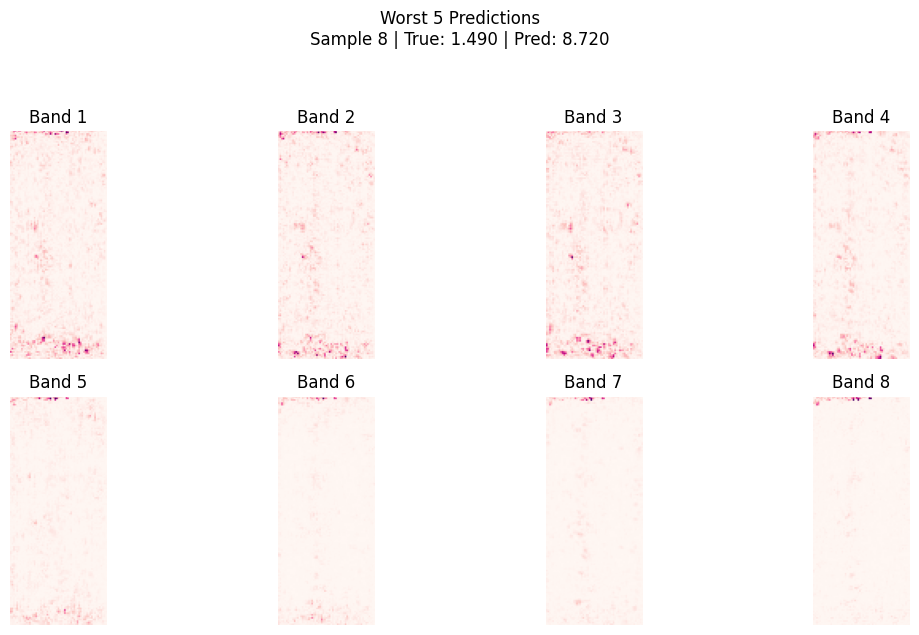

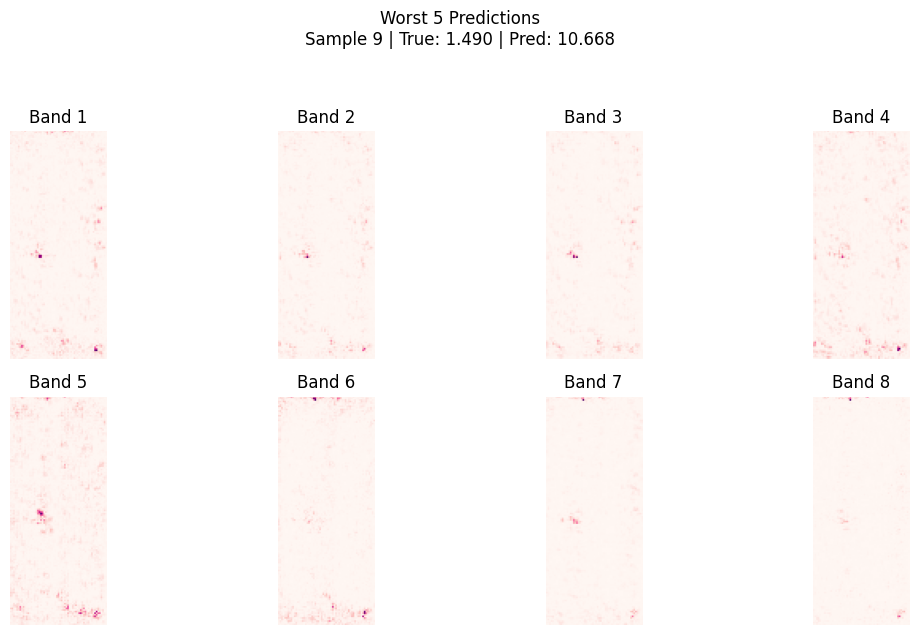

In [47]:
def plot_shap_images_per_band(X, shap_values, y_true, y_pred, indices, title):
    """
    Visualize SHAP values per spectral band for selected samples.
    Each sample shows 8 small heatmaps (one per band).

    Parameters:
        X (np.ndarray): Image data (N, H, W, C)
        shap_values (np.ndarray): SHAP values (N, H, W, C)
        y_true (array): True values
        y_pred (array): Predicted values
        indices (iterable): Sample indices to plot
        title (str): Plot title
    """
    for idx in indices:
        img = X[idx]
        shap_img = np.abs(shap_values[idx])  # absolute SHAP values per pixel/band

        fig, axes = plt.subplots(2, 4, figsize=(12, 6))
        fig.suptitle(f"{title}\nSample {idx} | True: {y_true[idx]:.3f} | Pred: {y_pred[idx]:.3f}",
                     fontsize=12, y=1.05)

        for b in range(8):  # assuming 8 bands
            ax = axes[b // 4, b % 4]
            ax.imshow(shap_img[..., b], cmap='RdPu')
            ax.set_title(f"Band {b+1}")
            ax.axis("off")

        plt.tight_layout()
        plt.show()

plot_shap_images_per_band(X_selected, shap_sum, y_true_selected, y_pred_selected, range(0, 5), "Best 5 Predictions")
plot_shap_images_per_band(X_selected, shap_sum, y_true_selected, y_pred_selected, range(5, 10), "Worst 5 Predictions")

In [15]:
np.max(Y)

10.192